In [155]:
#!pip install tensorflow_datasets

In [156]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [157]:
# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import logging

In [158]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [159]:
dataset,info=tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [160]:
dataset

{'train': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 'test': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}

In [161]:
info.features['label'].names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [162]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [163]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

In [164]:
# The map function applies the normalize function to each element in the train 
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [165]:
# Take a single image
for image, label in test_dataset.take(1):
    break

In [166]:
print(type(image))
print(type(image.numpy()))
print(image.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
(28, 28, 1)


In [167]:
# remove color dimension by reshaping
image = image.numpy().reshape((28,28))

print(type(image))
print(image.shape)

<class 'numpy.ndarray'>
(28, 28)


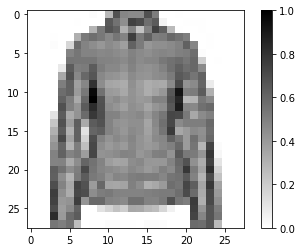

In [168]:
# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [169]:
class_names = info.features['label'].names

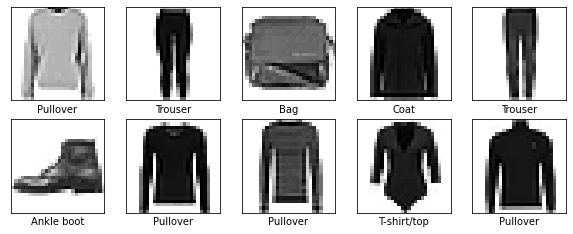

In [170]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(10)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [171]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [172]:
model.compile(optimizer=tf.optimizers.RMSprop(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [173]:
len(train_dataset)

60000

In [174]:
batch_size=32
train_dataset = train_dataset.cache().repeat().shuffle(info.splits['train'].num_examples).batch(batch_size)

In [175]:
#len(train_dataset) #TypeError: The dataset is infinite.

In [176]:
test_dataset = test_dataset.cache().repeat().shuffle(info.splits['test'].num_examples).batch(batch_size)

In [177]:
y_test_loss, y_test_accuracy = model.evaluate(test_dataset, steps=math.ceil(info.splits['test'].num_examples/batch_size))
print('Accuracy on test dataset before training:', y_test_accuracy)

313/313 [==============================] - 1s 1ms/step - loss: 2.3916 - accuracy: 0.0997
Accuracy on test dataset before training: 0.0997404158115387


In [178]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(info.splits['test'].num_examples/batch_size))

Epoch 1/5
313/313 [==============================] - 2s 1ms/step - loss: 0.7184 - accuracy: 0.7506
Epoch 2/5
313/313 [==============================] - 0s 1ms/step - loss: 0.5157 - accuracy: 0.8198
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 0.4790 - accuracy: 0.8329
Epoch 4/5
313/313 [==============================] - 0s 1ms/step - loss: 0.4451 - accuracy: 0.8427
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.4221 - accuracy: 0.8489


In [179]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
predictions = model.predict(test_images)

actual label: 7


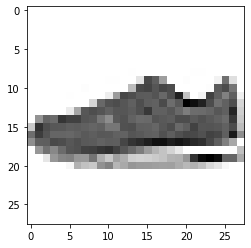

In [180]:
plt.imshow(test_images[0], cmap=plt.cm.binary)
print('actual label: {}'.format(test_labels[0]))

In [181]:
predictions.shape

(32, 10)

In [182]:
print('Predicted label: {}'.format(np.argmax(predictions[0])))
print('actual label: {}'.format(test_labels[0]))

Predicted label: 7
actual label: 7


In [183]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    #plt.imshow(img[...,0], cmap=plt.cm.binary)
    plt.imshow(img, cmap=plt.cm.binary)
    #print(predictions_array)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


In [184]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

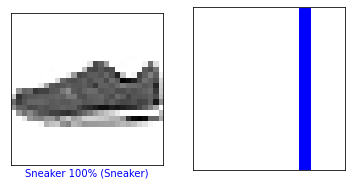

In [185]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [186]:
np.max(9.8647690e-01)*100

98.64769

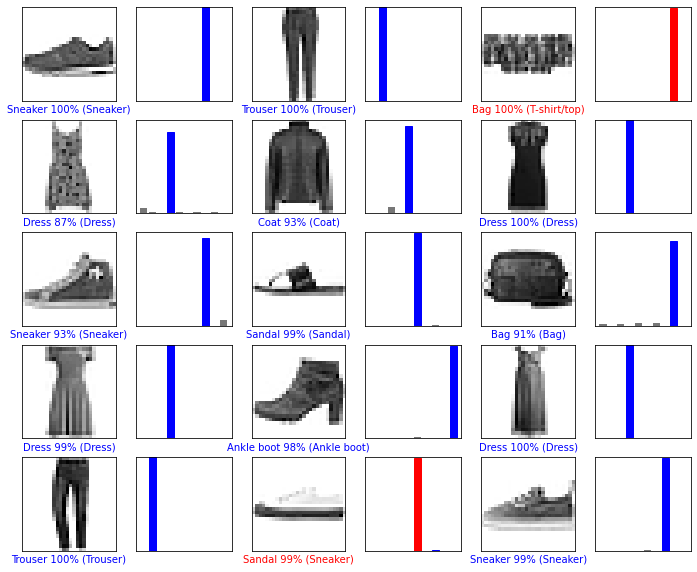

In [187]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


### Implementing Convolution layer

In [188]:
train_dataset_cnn, test_dataset_cnn = dataset['train'], dataset['test']

train_dataset_cnn =  train_dataset_cnn.map(normalize)
test_dataset_cnn  =  test_dataset_cnn.map(normalize)

train_dataset_cnn =  train_dataset_cnn.cache()
test_dataset_cnn  =  test_dataset_cnn.cache()

In [189]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [190]:
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [191]:
num_train_examples=info.splits['train'].num_examples
num_test_examples=info.splits['test'].num_examples

In [192]:
batch_size=32
train_dataset_cnn = train_dataset_cnn.cache().repeat().shuffle(num_train_examples).batch(batch_size=32)
test_dataset_cnn = test_dataset_cnn.cache().batch(batch_size=32)


In [193]:

model_cnn.fit(train_dataset_cnn, epochs=10, steps_per_epoch=math.ceil(num_train_examples/batch_size))

Epoch 1/10
1875/1875 [==============================] - 65s 34ms/step - loss: 0.3998 - accuracy: 0.8546
Epoch 2/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2586 - accuracy: 0.9047
Epoch 3/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.2178 - accuracy: 0.9212
Epoch 4/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.1844 - accuracy: 0.9316
Epoch 5/10
1875/1875 [==============================] - 70s 38ms/step - loss: 0.1573 - accuracy: 0.9414
Epoch 6/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.1379 - accuracy: 0.9480
Epoch 7/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.1163 - accuracy: 0.9563
Epoch 8/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0975 - accuracy: 0.9640
Epoch 9/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0828 - accuracy: 0.9695
Epoch 10/10
1875/1875 [==============================] - 58s 31m

In [196]:
y_loss_cnn, y_accuracy_cnn = model.evaluate(test_dataset_cnn, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', y_accuracy_cnn)

313/313 [==============================] - 1s 2ms/step - loss: 0.4842 - accuracy: 0.8346
Accuracy on test dataset: 0.8345999717712402


In [199]:
for test_images, test_labels in test_dataset_cnn.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()

predictions = model_cnn.predict(test_images)
#np.argmax(predictions[0])
print('Predicted label: {}'.format(np.argmax(predictions[0])))
print('actual label: {}'.format(test_labels[0]))

Predicted label: 4
actual label: 4
